<a href="https://colab.research.google.com/github/Zeusfire2058/code_stuff_woo/blob/master/Lorenz_63.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install deepxde

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.2/194.2 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 7.9 MB/s eta 0:00:00


Observation times from t=100.0 to 110.0 with 101 points
Time between observations: 0.09999999999999432 (should be 0.1)
Generating reference solution for initial condition 0/1000
Generating reference solution for initial condition 100/1000
Generating reference solution for initial condition 200/1000
Generating reference solution for initial condition 300/1000
Generating reference solution for initial condition 400/1000
Generating reference solution for initial condition 500/1000
Generating reference solution for initial condition 600/1000
Generating reference solution for initial condition 700/1000
Generating reference solution for initial condition 800/1000
Generating reference solution for initial condition 900/1000


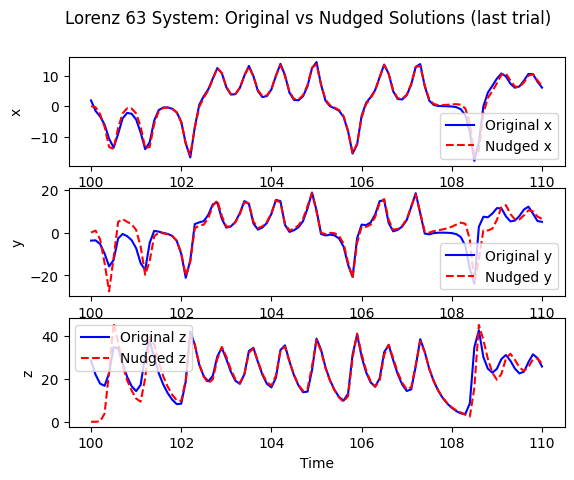


=== Verification ===
Number of initial conditions (Ns): 1000
Observations per simulation: 100 (from 101 time points)
Expected total samples: 100000 (Ns × 100)
Actual input_data shape: (100000, 4) (should be (100000, 4))
Actual output_data shape: (100000, 3) (should be (100000, 3))
Compiling model...
Building feed-forward neural network...
'build' took 0.095286 s

'compile' took 0.486452 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [2.66e+02]    [2.65e+02]    [1.00e+00]    
Epoch 1: train loss improved from inf to 2.66e+02, saving model to ./codes/model-1.ckpt ...

1000      [5.41e+00]    [5.65e+00]    [1.46e-01]    
Epoch 1000: train loss improved from 2.66e+02 to 5.41e+00, saving model to ./codes/model-1000.ckpt ...

2000      [7.57e-01]    [9.45e-01]    [5.99e-02]    
Epoch 2000: train loss improved from 5.41e+00 to 7.57e-01, saving model to ./codes/model-2000.ckpt ...


Best model at step 2000:
  train loss: 7.57e-01
  test loss: 9.45e-01
  t

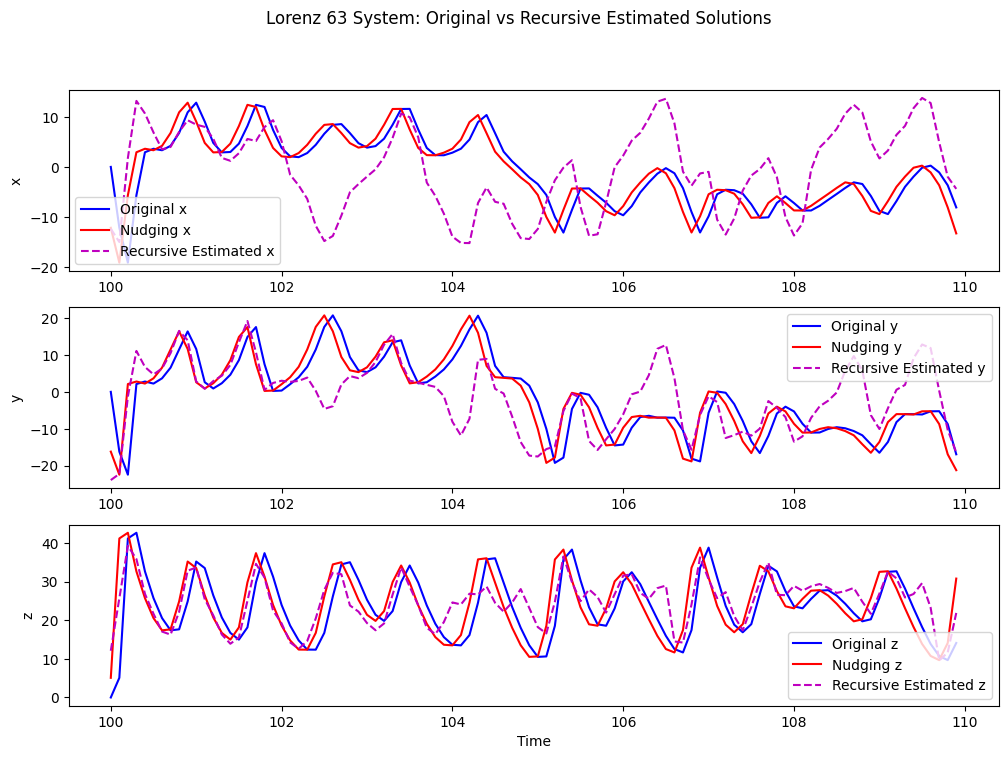

In [ ]:
import deepxde as dde
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.layers import TFSMLayer
import os

#time variable for linespace
num_reference_solutions = 1000  # N_s
total_simulation_time = 110  # Simulate up to t=110
observation_start_time = 100  # Start recording observations at t=100
observations_per_time_unit = 10  # δ = 0.1 time units between observations
delta_t = 1.0/observations_per_time_unit  # 0.1

# Create observation times (from 100 to 110, every 0.1 units)
num_observations = int((total_simulation_time - observation_start_time) / delta_t) + 1
observation_times = np.linspace(observation_start_time, total_simulation_time, num_observations)

    # Full simulation times (from 0 to 110 - needed for the ODE solver)
full_simulation_times = np.linspace(0, total_simulation_time,
                                    int(total_simulation_time * observations_per_time_unit) + 1)


class Lorenz63:
    def __init__(self, sigma=10.0, rho=28.0, beta=8/3):
        self.sigma = sigma
        self.rho = rho
        self.beta = beta

    def original_system(self, state, t):
        x, y, z = state

        # system equations
        dxdt = self.sigma * (y - x)
        dydt = x * (self.rho - z) - y
        dzdt = x * y - self.beta * z

        return [dxdt, dydt, dzdt]

    def nudged_system(self, state, t, x_observed, mu):
        x_bar, y_bar, z_bar = state

        # Get the observed x value at time t (needs interpolation)
        x = np.interp(t, x_observed[:, 0], x_observed[:, 1])

        # system equations
        dxdt_bar = self.sigma * (y_bar - x_bar) - mu * (x_bar - x) # with nudging term!
        dydt_bar = x_bar * (self.rho - z_bar) - y_bar
        dzdt_bar = x_bar * y_bar - self.beta * z_bar

        return [dxdt_bar, dydt_bar, dzdt_bar]
#Make Training Data
def simulate_lorenz_with_nudging():
    # Parameters
    sigma = 10.0
    rho = 28.0
    beta = 8/3
    mu = 30  # Nudging parameter

    num_reference_solutions = 1000  # N_s
    total_simulation_time = 110  # Simulate up to t=110
    observation_start_time = 100  # Start recording observations at t=100
    observations_per_time_unit = 10  # δ = 0.1 time units between observations
    delta_t = 1.0/observations_per_time_unit  # 0.1

    # Create observation times (from 100 to 110, every 0.1 units)
    num_observations = int((total_simulation_time - observation_start_time) / delta_t) + 1
    observation_times = np.linspace(observation_start_time, total_simulation_time, num_observations)

    # Verify observation times
    print(f"Observation times from t={observation_times[0]} to {observation_times[-1]} with {len(observation_times)} points")
    print(f"Time between observations: {observation_times[1] - observation_times[0]} (should be {delta_t})")

    # Full simulation times (from 0 to 110 - needed for the ODE solver)
    full_simulation_times = np.linspace(0, total_simulation_time,
                                       int(total_simulation_time * observations_per_time_unit) + 1)

    input_samples = [] # stores (x_bar, y_bar, z_bar, observed x) @ time t
    output_samples = [] # stores (x_bar, y_bar, z_bar) @ time t+1

    for i in range(num_reference_solutions):
        # Display progress of generating solutions
        if i % 100 == 0:
            print(f"Generating reference solution for initial condition {i}/{num_reference_solutions}")

        # Generate random initial conditions from N(0, 10)
        x0, y0, z0 = np.random.normal(loc=0, scale=10, size=3)

        # Simulate true system from t=0 to t=110
        lorenz = Lorenz63(sigma, rho, beta)
        true_solution = odeint(lorenz.original_system, [x0, y0, z0], full_simulation_times)

        # Extract only the observation period (t=100 to t=110)
        obs_indices = (full_simulation_times >= observation_start_time)
        observed_times = full_simulation_times[obs_indices]
        observed_states = true_solution[obs_indices]

        # Verify we have correct number of observation points
        assert len(observed_times) == num_observations, \
               f"Expected {num_observations} observations, got {len(observed_times)}"

        # Create observations (x-component only) during observation period
        x_observed = np.column_stack((observed_times, observed_states[:, 0]))

        # Simulate nudged system during observation period only
        nudged_solution = odeint(lorenz.nudged_system, [0, 0, 0], observed_times, args=(x_observed, mu))

        # Create training pairs (Algorithm 3.1)
        for k in range(len(observed_times) - 1):
            # Input: [w(t_k), I_M(u(t_k))]
            current_state = nudged_solution[k]
            current_obs = x_observed[k, 1]  # x(t_k)
            input_pair = np.concatenate([current_state, [current_obs]])

            # Output: w(t_{k+1})
            next_state = nudged_solution[k + 1]

            input_samples.append(input_pair)
            output_samples.append(next_state)

    # Convert to numpy arrays
    input_data = np.array(input_samples)
    output_data = np.array(output_samples)

    # Plot results
     # Extract the portion of true_solution corresponding to observation_times
    true_solution_obs_period = true_solution[obs_indices]

    # Plot x components
    plt.subplot(3, 1, 1)
    plt.plot(observation_times, true_solution_obs_period[:, 0], 'b-', label='Original x')
    plt.plot(observation_times, nudged_solution[:, 0], 'r--', label='Nudged x')
    plt.ylabel('x')
    plt.legend()

    # Plot y components
    plt.subplot(3, 1, 2)
    plt.plot(observation_times, true_solution_obs_period[:, 1], 'b-', label='Original y')
    plt.plot(observation_times, nudged_solution[:, 1], 'r--', label='Nudged y')
    plt.ylabel('y')
    plt.legend()

    # Plot z components
    plt.subplot(3, 1, 3)
    plt.plot(observation_times, true_solution_obs_period[:, 2], 'b-', label='Original z')
    plt.plot(observation_times, nudged_solution[:, 2], 'r--', label='Nudged z')
    plt.ylabel('z')
    plt.xlabel('Time')
    plt.legend()

    plt.suptitle('Lorenz 63 System: Original vs Nudged Solutions (last trial)')
    plt.show()

    # Extract the portion of true_solution corresponding to observation_times
    true_solution_obs_period = true_solution[obs_indices]

    # Verification
    print("\n=== Verification ===")
    print(f"Number of initial conditions (Ns): {num_reference_solutions}")
    print(f"Observations per simulation: {num_observations - 1} (from {num_observations} time points)")
    expected_total_samples = num_reference_solutions * (num_observations - 1)
    print(f"Expected total samples: {expected_total_samples} (Ns × {num_observations - 1})")
    print(f"Actual input_data shape: {input_data.shape} (should be ({expected_total_samples}, 4))")
    print(f"Actual output_data shape: {output_data.shape} (should be ({expected_total_samples}, 3))")

    assert input_data.shape == (expected_total_samples, 4), "Input data shape mismatch"
    assert output_data.shape == (expected_total_samples, 3), "Output data shape mismatch"

    return input_data, output_data

# Run the simulation
input, nudged = simulate_lorenz_with_nudging()

# crop to just the first N x N_s samples
N = 15
num_reference_solutions = 1000 # Define N_s here
input = input[:num_reference_solutions * N]
nudged = nudged[:num_reference_solutions * N]



############################################################
# Algorithm 3.2: Online Usage of DNN for Data Assimilation #
############################################################
# 1: Initialize wDNN (t0) = 0 (or arbitrary)               #
# 2: Observe IM (ui(t0))                                   #
# 3: Set k = 0                                             #
# 4: while Observations are available do                   #
# 5:      wDNN (tk+1) = DNN (wDNN (tk), IM (ui(tk))        #
# 6:      Observe IM (ui(tk+1))                            #
# 7:      k = k + 1                                        #
# 8: end while                                             #
############################################################

#define Lorenz 63 Model
X_train, X_test, y_train, y_test = train_test_split(input, nudged, train_size=0.8)


data = dde.data.Triple(X_train, y_train, X_test , y_test = y_test)
net = dde.nn.FNN([4] + [50] * 3 + [3], "tanh", "Glorot normal")

model_63 = dde.Model(data, net)
model_63.compile("adam", lr=0.001, metrics = ["l2 relative error"])
checkpointer = dde.callbacks.ModelCheckpoint("./codes/model", verbose=1, save_better_only= True)
loss_history, train_state = model_63.train(epochs=2000, callbacks=[checkpointer])
model_63.restore("./codes/model-"+ str(train_state.best_step) + ".ckpt", verbose=1)
#loaded_model = model_63.restore("./codes/model-"+ str(train_state.best_step) + ".ckpt", verbose=1)
'''
# Define checkpoint path
save_dir = "/content/checkpoints"
os.makedirs(save_dir, exist_ok=True)
model_path = os.path.join(save_dir, "model_63.h5")  # HDF5 format
'''
#################################################################################
#Create test data for graphs
def test_lorenz_with_nudging():
    # Parameters
    sigma = 10.0
    rho = 28.0
    beta = 8/3
    mu = 5.0  # Nudging parameter

    input_test_samples = [] # stores <num_reference_solutions> many (x_bar, y_bar, z_bar, observed x) @ time t
    output_test_samples = [] # stores <num_reference_solutions> many (x_bar, y_bar, z_bar) @ time t+1
    recursive_predictions = []

    for i in range(1):
        # Display progress of generating solutions
        if i % 100 == 0:
            print(f"Generating reference solution {i}/{1}")

        # Generate random initial conditions
        x0, y0, z0 = np.random.normal(loc=0, scale=50, size=3)

        # Simulate true system
        lorenz = Lorenz63(sigma, rho, beta)
        true_solution = odeint(lorenz.original_system, [x0, y0, z0], observation_times)

        # Create observations (x-component only)
        x_observed = np.column_stack((observation_times, true_solution[:, 0])) # I_M(u^i(t_k))

        # Simulate nudged system
        nudged_solution = odeint(lorenz.nudged_system, [0, 0, 0], observation_times, args=(x_observed, mu)) # W^i(t_k)

        # Create training pairs (Algorithm 3.1)
        for k in range(len(observation_times) -  1):
            # Input: [w(t_k), I_M(u(t_k))]
            current_state = nudged_solution[k]
            current_obs = x_observed[k, 1]  # x(t_k)
            input_pair = np.concatenate([current_state, [current_obs]])

            # Output: w(t_{k+1})
            next_state = nudged_solution[k + 1]

            input_test_samples.append(input_pair)
            output_test_samples.append(next_state)

        # Create training pairs (Algorithm 3.2)
        for k in range(len(observation_times) - 1): #-2 to make it the same length as others


            current_state = nudged_solution[k]
            current_obs = x_observed[k, 1]  # x(t_k)
            current_input = np.concatenate([current_state, [current_obs]])

    # Reshape the input to match the model's expected input shape (batch_size, input_dim)
            current_input = current_input.reshape(1, -1)

    # Predict the next state: w(t_{k+1})
            next_state_prediction = model_63.predict(current_input)

    # Extract the predicted state (remove the batch dimension)
            next_state_prediction = next_state_prediction[0]

    # Store the prediction
            recursive_predictions.append(next_state_prediction)

    # Update the current state for the next iteration
            current_state = next_state_prediction


    # Convert to numpy arrays
    input_test_data = np.array(input_test_samples)
    output_test_data = np.array(output_test_samples)
    recursive_pred_data = np.array(recursive_predictions)

    return input_test_data, output_test_data, recursive_pred_data

# Run the test simulation for graphs
original_test, nudged_test, recursive_test = test_lorenz_with_nudging()

###############################################################################


'''
# Get the initial state from the nudged solution of the test data
initial_state = nudged_test[0]

# Get the observed x values from the test data
# We need the observed x at t_k for each step
observed_x_test = original_test[:, 0]

# Initialize the array to store the recursive predictions
recursive_predictions = [initial_state]

# Perform recursive prediction
current_state = initial_state
for k in range(len(observation_times) - 2): #-2 to make it the same length as others
    # Construct the input for the current step: [w(t_k), I_M(u(t_k))]
    # Use the predicted state from the previous step (or initial_state for the first step)
    # and the observed x at the current time step t_k
    current_input = np.concatenate([current_state, [observed_x_test[k]]])

    # Reshape the input to match the model's expected input shape (batch_size, input_dim)
    current_input = current_input.reshape(1, -1)

    # Predict the next state: w(t_{k+1})
    next_state_prediction = model_63.predict(current_input)

    # Extract the predicted state (remove the batch dimension)
    next_state_prediction = next_state_prediction[0]

    # Store the prediction
    recursive_predictions.append(next_state_prediction)

    # Update the current state for the next iteration
    current_state = next_state_prediction
'''

# Extract the components for plotting
x_recursive = recursive_test[:, 0]
y_recursive = recursive_test[:, 1]
z_recursive = recursive_test[:, 2]
t = observation_times[:len(original_test)]

# Plotting the results
plt.figure(figsize=(12, 8))

# Plot x components
plt.subplot(3, 1, 1)
plt.plot(t, original_test[:, 0], 'b-', label='Original x')
plt.plot(t, nudged_test[:, 0], 'r-', label = 'Nudging x')
plt.plot(t, x_recursive, 'm--', label='Recursive Estimated x')
plt.ylabel('x')
plt.legend()

# Plot y components
plt.subplot(3, 1, 2)
plt.plot(t, original_test[:, 1], 'b-', label='Original y')
plt.plot(t, nudged_test[:, 1], 'r-', label = 'Nudging y')
plt.plot(t, y_recursive, 'm--', label='Recursive Estimated y')
plt.ylabel('y')
plt.legend()

# Plot z components
plt.subplot(3, 1, 3)
plt.plot(t, original_test[:, 2], 'b-', label='Original z')
plt.plot(t, nudged_test[:, 2], 'r-', label = 'Nudging z')
plt.plot(t, z_recursive, 'm--', label='Recursive Estimated z')
plt.ylabel('z')
plt.xlabel('Time')
plt.legend()

plt.suptitle('Lorenz 63 System: Original vs Recursive Estimated Solutions')
plt.show()


